In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce
import os
import sys
import time
import numpy as np
import cPickle as pickle

In [48]:
def draw_true_samples(nsamp, samp_type, *argv):
    '''For 2d_gaussian, *argv arguments are mu_0, mu_1, sig_1, sig_2, rho'''
    if samp_type=='2d_gaussian':
        mus = np.array([argv[0], argv[1]])
        sigs = [argv[2], argv[3]]
        rho = argv[4]
        cov = np.array([[sigs[0]**2, rho*sigs[0]*sigs[1]],[rho*sigs[0]*sigs[1], sigs[1]**2]])
        s = torch.from_numpy(np.random.multivariate_normal(mus, cov, nsamp))
    
    elif samp_type=='1d_gaussian':
        mu = argv[0]
        sig = argv[1]
        s = torch.from_numpy(np.random.normal(mu, sig, nsamp))
    
    elif samp_type=='bernoulli':
        n = argv[0]
        p = argv[1]
        s = torch.from_numpy(np.random.binomial(n, p, nsamp))
    
    ''' ring returns samples from equally spaced points around a circle with some scatter '''
    elif samp_type == 'ring':
        k = argv[0]
        std = argv[1]
        m = means_circle(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        s = torch.randn(nsamp, 2) * std + m[i]
    
    ''' grid returns samples from equally spaced points on a grid with some scatter. only seems to work for odd numbers '''
    elif samp_type == 'grid':
        k = argv[0]
        std = argv[1]
        m = means_grid(k)
        i = torch.zeros(nsamp).random_(m.size(0)).long()
        print i
        s = torch.randn(nsamp, 2) * std + m[i]

    ''' noise returns samples of standard normal noise which is used by the generator'''
    elif samp_type=='noise':
        n_latent = argv[0]
        s = torch.randn(nsamp, n_latent)

    return s

def means_circle(k=8):
    p = 3.14159265359
    t = torch.linspace(0, 2 * p - (2 * p / k), k)
    m = torch.cat((torch.sin(t).view(-1, 1),torch.cos(t).view(-1, 1)), 1)
    return m

def means_grid(k=25):
    m = torch.zeros(k, 2)
    s = int(torch.sqrt(torch.Tensor([k]))[0] / 2)
    cnt = 0
    for i in xrange(-s, s + 1):
        for j in xrange(-s, s + 1):
            m[cnt][0] = i
            m[cnt][1] = j
            cnt += 1
    return m / s

In [ ]:
LCDM = dict({'Om_b_h2':[0.02, 0.00014], 'Om_c_h2':[0.1188, 0.001], 't0':[13.799e9, 0.021e9], 'ns':[0.9667, 0.004], 'delta_r_2':[2.441e-9, 0.09e-9], 'tau':[0.066, 0.012]})

def sample_LCDM():
    params = []
    for key in LCDM:
        print key
        print LCDM[key][0], LCDM[key][1]
        params.append(np.random.normal(LCDM[key][0], LCDM[key][1]))
    
    print 'params'
    print params
sample_LCDM()

In [8]:
class Perceptron(torch.nn.Module):
    def __init__(self, sizes, final=None):
        super(Perceptron, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                layers.append(torch.nn.ReLU())
        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
   
    
def sample_noise(bs, d):
    z = torch.randn(bs, d).float()
    return Variable(z.to(Device), requires_grad=True)
    
def restore_nn(filepath):
    # get config parameters from run and use to construct Perceptron object
    filen = open(filepath+'/params.txt','r')
    pdict = pickle.load(filen)
#     pdict['latent_dim'] = 2
    model = Perceptron([pdict['latent_dim']+pdict['n_cond_params']] + [pdict['n_hidden']] * pdict['n_layers'] + [pdict['n_out']])
    model.load_state_dict(torch.load(filepath+'/netG'))
    model.eval()
    
    return model, pdict

In [41]:
from scipy import stats

basedir = '/Users/richardfeder/Documents/caltech/gan_work/results/'
mutrue, stdtrue = 3.4, 0.5

def generate_samples(G, pdict, nsamp, cond_params=None):
    arr = np.zeros((nsamp, pdict['n_out']))
    
    z = torch.randn(nsamp, pdict['latent_dim']).float()
    
    gen_input = torch.from_numpy(np.tile(cond_params, (nsamp, 1))).float()
    gen_input = torch.cat((z, gen_input), 1)
    
    arr = G(gen_input).detach().numpy()
            
    return arr

def make_comparison_plot(true, fake, ks=None, save=None):
    muf, stdf = np.mean(fake), np.std(fake)
    print muf, stdf
    
    plt.figure()
    if ks is not None:
        plt.title('KS Statistic D = '+ str(np.round(ks.statistic, 5)))
    _, bins, _ = plt.hist(true, histtype='step', label='True', bins=20)
    plt.hist(fake, histtype='step', bins=bins, label='Generated')
    plt.legend()
    if save is not None:
        plt.savefig(save+'.png', bbox_inches='tight')
    plt.show()
    

''' Kolmogorov-Smirnov Test on True vs. Generated Samples. This test only applies to 1D distributions. 

    Inputs: 
        gen_array (N,) -- an ndarray with samples from the generator
        cond_params (n_cond,) -- a list of length n_cond specifying conditional parameters of distribution denoted by samp_type
        samp_type -- a str specifying type of distribution to sample
        
    Output:
        ks -- an object with KS statistic and p-value (D, p)
'''
def ks_test(gen_array, cond_params, samp_type='norm'):
    if samp_type=='norm':
        ks = stats.ks_2samp(np.random.normal(cond_params[0], cond_params[1], 100000), arr)
#         ks = stats.kstest(arr, lambda x: stats.norm.cdf(x, loc=cond_params[0], scale=cond_params[1]))
#     print ks
    return ks

def kl_divergence(gen_array, cond_params, samp_type='norm'):
    if samp_type =='norm':
        true = np.random.normal(cond_params[0], cond_params[1], 10000)
    
    true_hist, bins = np.histogram(true, density=True)
    gen_hist, _ = np.histogram(gen_array, density=True, bins=bins)

    kl = stats.entropy(true_hist+1e-5, gen_hist+1e-5)
    return kl
        


def test_cGAN(timestr, cond_params=None, nsamp=10000):
    netG, pdict = restore_nn(basedir+timestr)
    print pdict
    if cond_params is None:
        cond_params = [mutrue, stdtrue]
    print 'Conditional parameters:', cond_params
    arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
    ks = ks_test(arr, cond_params)
    kl = kl_divergence(arr, cond_params)
#     print 'KL Divergence:', kl
    real = np.random.normal(cond_params[0], cond_params[1], nsamp)
    frame_dir = basedir+timedir+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
    make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    

# test_cGAN('20190123-150922', cond_params=[1.5, 1.5])

In [7]:
def ks_test_cGAN(timestr, vals, nsamp=1000, plot=True, save=False):
    netG, pdict = restore_nn(basedir+timestr)
    
    Ds = []
    ps = []
    KL = []
    mus, sigs = [], []
    for val in vals:
        cond_params = [0.0, val]
#         cond_params = [val, 1.0]
        arr = generate_samples(netG, pdict, nsamp, cond_params=cond_params)
        mus.append(np.mean(arr))
        sigs.append(np.std(arr))
        ks = ks_test(arr, cond_params)
        kl = kl_divergence(arr, cond_params)
        Ds.append(ks.statistic)
        ps.append(ks.pvalue)
        KL.append(kl)
        
        real = np.random.normal(cond_params[0], cond_params[1], arr.shape[0])
        frame_dir = basedir+timestr+'/frames/'+str(cond_params[0])+'_'+str(cond_params[1])
        make_comparison_plot(real, arr, ks=ks, save=frame_dir)
    
        
    if plot:
        plt.figure()
        plt.plot(vals, Ds, marker='o')
        plt.axhline(1.36/np.sqrt(1000), linestyle='dashed', label='$D_{crit}$ (95 percent)')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylim(0, 1)
        plt.ylabel('KS Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/kstest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/kstest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
        plt.figure()
        plt.plot(vals, KL, marker='o')
        plt.xlabel('$\sigma$')
#         plt.xlabel('$\mu$')
        plt.ylabel('KL Divergence Statistic')
        plt.legend()
        if save:
#             plt.savefig(basedir+timestr+'/KLDivTest_mus.png', bbox_inches='tight')
            plt.savefig(basedir+timestr+'/KLDivTest_sig_mu=0.0.png', bbox_inches='tight')
        plt.show()
        
#         plt.figure(figsize=(9, 4))
#         plt.subplot(1,2,1)
#         plt.plot(vals, vals, label='Truth')
#         plt.plot(vals, mus, label='Generated')
# #         plt.plot(vals, sigs, label='Generated')
#         plt.xlabel('$\mu$ used in conditioning')
#         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
# #         plt.ylabel('$\sigma$ estimated')
#         plt.legend()
        
#         plt.subplot(1,2,2)
#         plt.axhline(1.0)
#         plt.plot(vals, sigs, label='Generated')
# #         plt.plot(vals, mus, label='Generated')
#         plt.ylabel('$\sigma$ estimated')
#         plt.xlabel('$\mu$ used in conditioning')
# #         plt.ylabel('$\mu$ estimated')
# #         plt.xlabel('$\sigma$ used in conditioning')
#         if save:
#             plt.savefig(basedir+timestr+'/fix_sig_change_mu.png', bbox_inches='tight')
# #             plt.savefig(basedir+timestr+'/fix_mu_change_sig_mu=0.5.png', bbox_inches='tight')

#         plt.show()

        
    return Ds, ps, KL
    
mus = np.linspace(-1, 1, 30)

sigs = np.linspace(0.01, 2, 20)

Ds, ps, KL = ks_test_cGAN('20190123-150922', sigs, save=True)


NameError: global name 'restore_nn' is not defined

In [99]:
cond_params = [0.0, 0.0, 1.1, 0.1, 0.0]
nsamp = 1000

mu_range = np.linspace(-1, 1, 30)
sig_range = np.linspace(0.01, 3, 30)

cond_params = [0.0, 0.0, 1.1, 0.1, 0.0]

cond_param_list = np.zeros((30, len(cond_params)))

for i, mu in enumerate(mu_range):
    cond_param_list[i,:] = cond_params
    cond_param_list[i,1] = mu
    

def compare_nns(timestr_list, labels, idx = 0, idx2s=[0], nsamp=1000, save=False):
  

    mu_range = np.linspace(-1, 1, 60)
    sig_range = np.linspace(0.01, 2, 60)

    nets = []
    pdicts = []
    
    for timestr in timestr_list:
        netG, pd = restore_nn(basedir + timestr)
        nets.append(netG)
        pdicts.append(pd)
    
    if pdicts[0]['sample_type']=='2d_gaussian':
        cond_params = [0.0, 1.0,0.0, 1.0, 0.0]
    elif pdicts[0]['sample_type']=='1d_gaussian':
        cond_params = [0.0, 1.0]

    
    cond_param_list = np.zeros((60, len(cond_params)))
    if idx==0 or idx==2 or idx==4:
        val_array = mu_range # same for correlation coefficient as mu
    elif idx==1 or idx==3:
        val_array = sig_range
    
    for i, val in enumerate(val_array):
        cond_param_list[i,:] = cond_params
        cond_param_list[i,idx] = val
        
    cparams = np.array(cond_param_list)


        
    deduce_params = [np.zeros((cparams.shape[0], len(cparams[0]))) for x in xrange(len(nets))]

    
    for i, cond_params in enumerate(cparams):
        for j in xrange(len(nets)):
            arr = generate_samples(nets[j], pdicts[j], nsamp, cond_params=cond_params)
            if pdicts[j]['sample_type']=='2d_gaussian':
                deduce_params[j][i,:] = np.array([np.mean(arr[:,0]),  np.std(arr[:,0]), np.mean(arr[:,1]), np.std(arr[:,1]), np.cov(arr[:,0], arr[:,1])[0,1]/(np.std(arr[:,0])*np.std(arr[:,1]))])
                pnamelist = ['$\mu_0$', '$\sigma_0$', '$\mu_1$', '$\sigma_1$', 'rho']  
                pnamelist_notex = ['mu_0', 'sigma_0','mu_1','sigma_1', 'rho']
            elif pdicts[j]['sample_type']=='1d_gaussian':
                deduce_params[j][i,:] = np.array([np.mean(arr), np.std(arr)])
                pnamelist = ['$\mu$', '$\sigma$']  
                pnamelist_notex = ['mu', 'sigma']
    

    fig = plt.figure(figsize=(6,10))
    for i, idx2 in enumerate(idx2s):
        plt.subplot(len(idx2s),1, i+1)
        plt.xlabel(pnamelist[idx])
        plt.ylabel(pnamelist[idx2])
        plt.ylim()
        plt.plot(cparams[:,idx], cparams[:,idx2], label='Truth')
        for j in xrange(len(nets)):
            plt.plot(cparams[:,idx], deduce_params[j][:,idx2], label=labels[j])
        if i==0:
            plt.legend()
    if save:
        plt.savefig(basedir+timestr_list[-1]+'/2_5_100_comp_nns_vary_'+pnamelist_notex[idx]+'.pdf', bbox_inches='tight')
    plt.show()
    
    return fig
        


In [247]:
plt.figure()
fig1.add_subplot(1,2,1)
fig2.add_subplot(1,2,2)
plt.show()

/Users/richardfeder/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


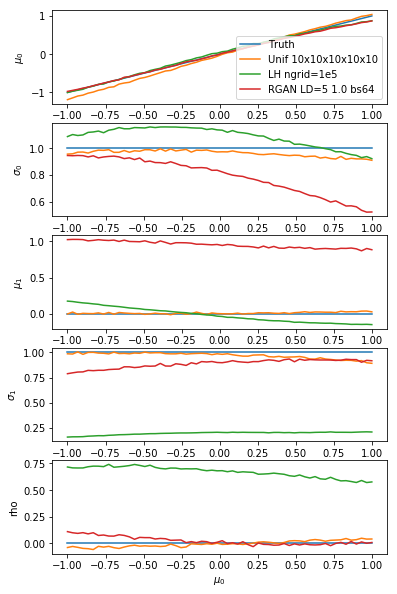

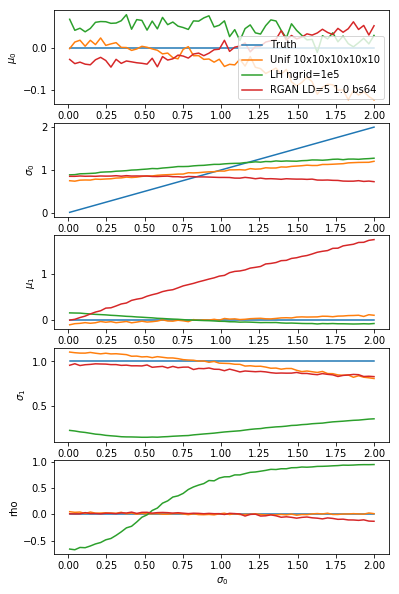

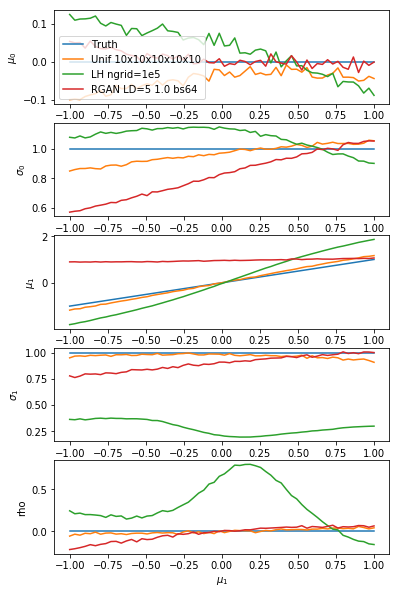

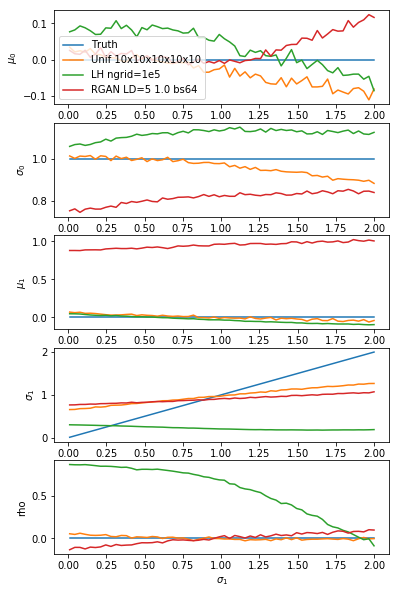

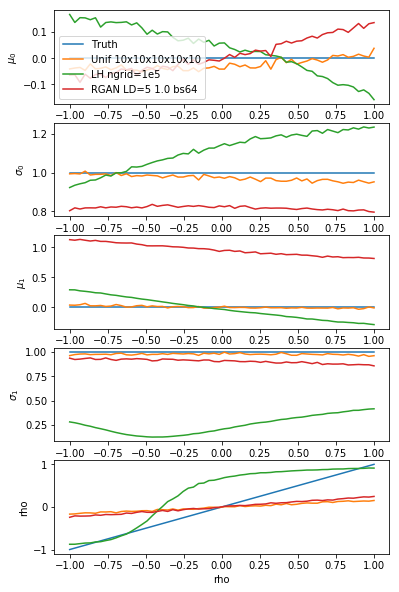

In [126]:
# timestr_list = ['20190126-114321', '20190126-114911', '20190126-124350']
# label_list = ['1d LD=1 NH=32', '1d LD=1 NH=64', 'NH=32 gamma=0.5']

# timestr_list = ['20190125-163106', '20190125-165642', '20190125-162524']
# label_list = ['RGAN 2000 gam=0.5', 'RGAN LD=5 gam=1.0 bs=64', 'RGAN 2000']

# timestr_list = ['20190126-135746', '20190126-135945', '20190126-140142', '20190126-140238']
# label_list = ['LH ngrid=16', 'Unif 4 x 4', 'LH ngrid=64', 'Unif 8 x 8']

# timestr_list = ['20190126-140901', '20190126-141142', '20190126-141703', '20190126-141807']
# label_list = ['LH ngrid=1024', 'Unif 4x4x4x4x4', 'Unif 10x10x10x10x10', 'LH ngrid=1e5']

timestr_list = ['20190126-142238', '20190126-141807', '20190125-165642']
label_list = ['Unif 10x10x10x10x10', 'LH ngrid=1e5', 'RGAN LD=5 1.0 bs64']
for x in xrange(5):
    fig1 = compare_nns(timestr_list, label_list, idx=x, idx2s=[0, 1, 2, 3, 4], save=False, nsamp=10000)


In [127]:
def LHS(array_list):
    d = len(array_list[0])
    LH_samples = np.zeros((d, len(array_list)))
    for i in xrange(d):
        samp = []
        for j in xrange(LH_samples.shape[1]):
            idx = np.random.randint(d-i)
            samp.append(array_list[j][idx])
            array_list[j] = np.delete(array_list[j], [idx])
        LH_samples[i,:] = np.array(samp)

    return LH_samples